# Task 8.2 – Melbourne Housing Regression

**Dataset:** melbourne_subset.csv (filtered Kaggle Melbourne Housing dataset)

This notebook includes:
- Data loading & inspection
- Cleaning & preprocessing
- Exploratory Data Analysis (EDA)
- Feature engineering
- Train/Test split
- 3 regression models with **5-fold cross-validation**
- Metrics: MAE, RMSE, R²
- Hyperparameter tuning
- Model comparison & selection
- Feature importance
- Model saving
- Gradio demo app

#### Imports essential libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

import joblib

Load Dataset

In [2]:
DATA_PATH = "../data/melbourne_subset.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (166, 21)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Melbourne,204/300 Swanston St,2,u,640000.0,VB,Greg,22/04/2017,2.8,3000.0,...,1.0,1.0,0.0,66.0,2005.0,Melbourne,-37.81060,144.96460,Northern Metropolitan,17496.0
1,Melbourne,43/1 Exhibition St,1,u,436000.0,S,RT,23/04/2016,2.8,3000.0,...,1.0,0.0,0.0,NaN,NaN,Melbourne,-37.81590,144.97200,Northern Metropolitan,17496.0
2,Melbourne,507/325 Collins St,2,u,733000.0,S,MICM,24/09/2016,2.8,3000.0,...,2.0,1.0,0.0,94.0,1965.0,Melbourne,-37.81660,144.96350,Northern Metropolitan,17496.0
3,Melbourne,709/87 Franklin St,2,u,565000.0,S,MICM,29/07/2017,0.0,3000.0,...,1.0,0.0,89.0,85.0,2003.0,Melbourne,-37.80802,144.96168,Northern Metropolitan,17496.0
4,Melbourne,402/455 Elizabeth St,2,u,452000.0,S,RT,13/05/2017,2.8,3000.0,...,1.0,0.0,0.0,60.0,2006.0,Melbourne,-37.80840,144.96020,Northern Metropolitan,17496.0


In [3]:
df.info()
df.describe(include="all").T
df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         166 non-null    object 
 1   Address        166 non-null    object 
 2   Rooms          166 non-null    int64  
 3   Type           166 non-null    object 
 4   Price          166 non-null    float64
 5   Method         166 non-null    object 
 6   SellerG        166 non-null    object 
 7   Date           166 non-null    object 
 8   Distance       166 non-null    float64
 9   Postcode       166 non-null    float64
 10  Bedroom2       166 non-null    float64
 11  Bathroom       166 non-null    float64
 12  Car            166 non-null    float64
 13  Landsize       166 non-null    float64
 14  BuildingArea   91 non-null     float64
 15  YearBuilt      114 non-null    float64
 16  CouncilArea    163 non-null    object 
 17  Lattitude      166 non-null    float64
 18  Longtitude

BuildingArea     75
YearBuilt        52
CouncilArea       3
Suburb            0
Bathroom          0
Regionname        0
Longtitude        0
Lattitude         0
Landsize          0
Car               0
Bedroom2          0
Address           0
Postcode          0
Distance          0
Date              0
SellerG           0
Method            0
Price             0
Type              0
Rooms             0
Propertycount     0
dtype: int64

### Data Cleaning

In [4]:
TARGET = "Price"

# Remove rows with missing target
df = df.dropna(subset=[TARGET])

# Drop ID-like columns if present
DROP_COLS = [c for c in ["Address", "Date"] if c in df.columns]
df = df.drop(columns=DROP_COLS)

print("Remaining shape:", df.shape)

Remaining shape: (166, 19)


## EDA: PRICE DISTRIBUTION

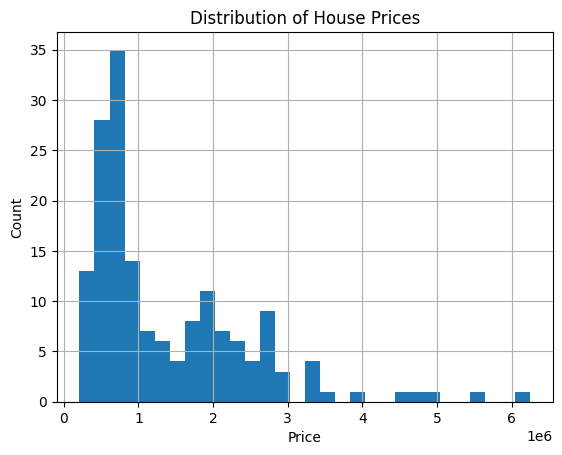

In [5]:
plt.figure()
df[TARGET].hist(bins=30)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


## EDA: PRICE BY SURBUB

<Figure size 640x480 with 0 Axes>

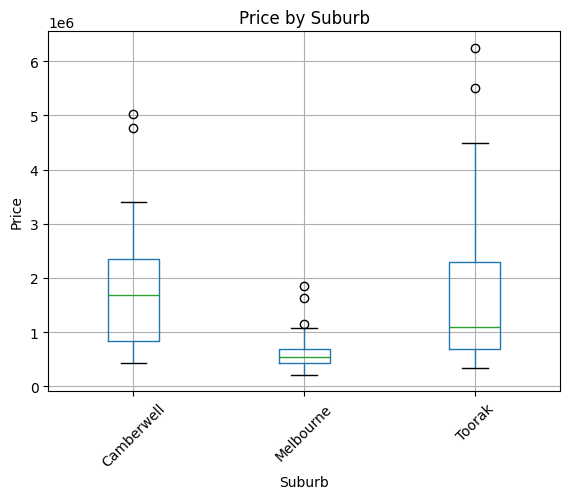

In [6]:
if "Suburb" in df.columns:
    plt.figure()
    df.boxplot(column=TARGET, by="Suburb", rot=45)
    plt.title("Price by Suburb")
    plt.suptitle("")
    plt.ylabel("Price")
    plt.show()


In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()[TARGET].sort_values(ascending=False)
corr

Price            1.000000
Bathroom         0.758449
Bedroom2         0.712356
Rooms            0.708584
Car              0.592868
Postcode         0.425597
Longtitude       0.373888
Distance         0.360374
BuildingArea     0.311173
Landsize         0.182299
YearBuilt       -0.223155
Lattitude       -0.341052
Propertycount   -0.420565
Name: Price, dtype: float64

In [8]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

pd.Series(X.columns).to_csv("feature_columns.csv", index=False, header=False)

X.to_csv("ui_reference.csv", index=False)

print("Saved feature_columns.csv and ui_reference.csv")

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_features, categorical_features

Saved feature_columns.csv and ui_reference.csv


(['Rooms',
  'Distance',
  'Postcode',
  'Bedroom2',
  'Bathroom',
  'Car',
  'Landsize',
  'BuildingArea',
  'YearBuilt',
  'Lattitude',
  'Longtitude',
  'Propertycount'],
 ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname'])

## Preprocessing pipelines

In [9]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

## Train and Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((132, 18), (34, 18))

## Cross Validation Setup

In [11]:
scoring = {
    "MAE": "neg_mean_absolute_error",
    "RMSE": "neg_root_mean_squared_error",
    "R2": "r2"
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)


# Model Definition

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}    

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    cv_result = cross_validate(pipe, X_train, y_train,
                               cv=cv, scoring=scoring)

    results.append({
        "Model": name,
        "MAE": -cv_result["test_MAE"].mean(),
        "RMSE": -cv_result["test_RMSE"].mean(),
        "R2": cv_result["test_R2"].mean()
    })

cv_df = pd.DataFrame(results).sort_values("RMSE")
cv_df

,Model,MAE,RMSE,R2
2,Gradient Boosting,342700.354764,486874.854976,0.772797
1,Random Forest,332910.745869,488217.291926,0.771751
0,Linear Regression,440935.438625,598781.690606,0.654965


## Hyperparameter Tuning (Random Forest)

In [13]:
rf_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

rf_params = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 10],
    "model__min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(
    rf_pipe,
    rf_params,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

rf_grid.best_params_



{'model__max_depth': None,
 'model__min_samples_split': 2,
 'model__n_estimators': 500}

## Test set Evaluation 

In [14]:
best_model = rf_grid.best_estimator_

y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, rmse, r2


(392249.07647058816, 541136402550.26, 0.6803478863991375)

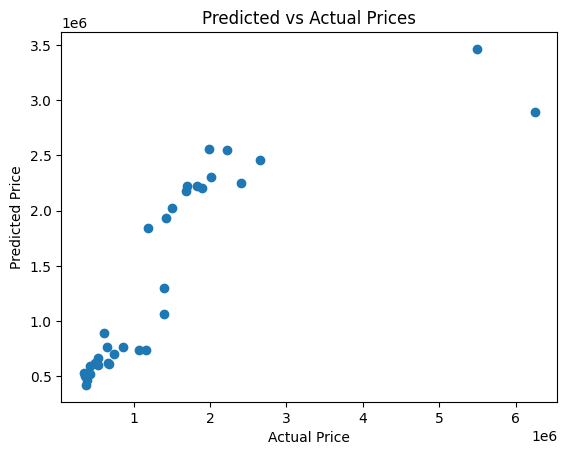

In [15]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.show()

## Feature Importance (Permutation)

In [16]:
perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=20, random_state=42, scoring="neg_root_mean_squared_error"
)

importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm.importances_mean
}).sort_values("Importance", ascending=False)

importance_df.head(10)


,Feature,Importance
2,Type,239575.922445
8,Bathroom,122699.177839
7,Bedroom2,72013.160279
11,BuildingArea,62216.099254
15,Longtitude,39774.026511
10,Landsize,33197.484778
1,Rooms,26989.109151
9,Car,15797.168879
14,Lattitude,7888.869940
3,Method,7505.725450


In [17]:
import joblib
joblib.dump(best_model, "melbourne_price_model.joblib")
print("Saved model to melbourne_price_model.joblib")

Saved model to melbourne_price_model.joblib
